In [1]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, OperatorStateFn
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
from qiskit_utils import BinaryObjectiveFunction
from data_utils import circle, plot_data, generate_ds
import numpy as np
# Set a random seed
np.random.seed(42)

In [2]:
# Generate training and test data
num_training = 200
num_test = 2000

X_train, y_train, new_y_train = generate_ds(num_training)
X_test, y_test, new_y_test= generate_ds(num_test)
print(X_test.shape)

(2000, 4)


In [3]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

In [5]:
from qiskit.quantum_info import DensityMatrix, Operator

inputs = ParameterVector('input', length=4) # 1 extra for label
weights = ParameterVector('weight', length=18)

# 1qubit classifier
qc1 = QuantumCircuit(1)
qc1.u(inputs[0]*weights[0]+weights[9],inputs[1]*weights[1]+weights[10],inputs[2]*weights[2]+weights[11], 0)
qc1.u(inputs[0]*weights[3]+weights[12],inputs[1]*weights[4]+weights[13],inputs[2]*weights[5]+weights[14], 0)
qc1.u(inputs[0]*weights[6]+weights[15],inputs[1]*weights[7]+weights[16],inputs[2]*weights[8]+weights[17], 0)

qc_sfn1 = StateFn(qc1)

H1 = StateFn(PauliSumOp.from_list([('Z', 1.0)]))  
H2 = StateFn(PauliSumOp.from_list([('Z', -1.0)]))  

op1 = ~H1 @ (qc_sfn1)
op2 = ~H2 @ (qc_sfn1)
print(op1)
print(len(weights))

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
       »
  q_0: »
       »
  «     ┌───────────────────────────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ U(input[0]*weight[0] + weight[9],input[1]*weight[1] + weight[10],input[2]*weight[2] + weight[11]) ├»
  «     └───────────────────────────────────────────────────────────────────────────────────────────────────┘»
  «     ┌────────────────────────────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ U(input[0]*weight[3] + weight[12],input[1]*weight[4] + weight[13],input[2]*weight[5] + weight[14]) ├»
  «     └────────────────────────────────────────────────────────────────────────────────────────────────────┘»
  «     ┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
  «q_0: ┤ U(input[0]*weight[6] + weight[15],input[1]*weight[7] + weight[16],input[2]*weight[8] + weight[17]) ├
  «     └──────────

In [7]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, inputs, weights, expval, gradient, qi_sv, input_gradients=True)
qnn2 = OpflowQNN(op2, inputs, weights, expval, gradient, qi_sv, input_gradients=True)

In [8]:
from qiskit.algorithms.optimizers import ADAM, L_BFGS_B
from qiskit_machine_learning.utils.loss_functions import L2Loss

losses = []
def callback_fn(avg_loss, weights):
    print("weights: ", weights)
    print("loss: ", avg_loss)
    losses.append(avg_loss)

function = BinaryObjectiveFunction(X_train, new_y_train, qnn1, qnn2, L2Loss(), callback_fn)

In [22]:
losses = []
# optimizer = ADAM(maxiter=30, lr=0.8)
optimizer = L_BFGS_B(maxiter=50)
# fit_result = optimizer.minimize(
fit_result = optimizer.optimize( 
    num_vars=qnn1.num_weights,
    objective_function=function.objective,
    initial_point=algorithm_globals.random.random(qnn1.num_weights),
    gradient_function=function.gradient,
)

print(fit_result)

<bound method BinaryObjectiveFunction.gradient of <__main__.BinaryObjectiveFunction object at 0x000002E21A64ED90>>
weights:  [0.76305617 0.92481225 0.95566011 0.97598949 0.21878838 0.3552154
 0.95058778 0.97135536 0.34448374 0.25196644 0.63806837 0.09177283
 0.44768711 0.67621512 0.60402817 0.30687257 0.98242761 0.66946822]
loss:  1.4775801958138441
weights:  [ 0.62267039  1.0428789   0.95566011  1.31172301  0.27136386  0.3552154
  0.98689795  0.97135536  0.34448374 -0.05401123  0.3182109   0.09177283
  0.30495428  0.19304025  0.2841707   0.05384295  0.98242761  0.18629335]
loss:  0.7233805443400908
weights:  [ 0.49526258  0.94829633  0.95566011  1.87189885  0.10939406  0.3552154
  1.24332782  0.97135536  0.34448374 -0.75307032 -0.05756517  0.09177283
 -0.42668136 -0.35634945 -0.09160537 -0.69483095  0.98242761 -0.36309635]
loss:  1.5781861099547667
weights:  [ 0.59998185  1.02603582  0.95566011  1.41147804  0.24252059  0.3552154
  1.03256249  0.97135536  0.34448374 -0.17849833  0.2512

loss:  0.38810503703504773
weights:  [-2.88285474  1.413878    0.95566011  2.8339684   1.52583261  0.3552154
  2.61669858  0.97135536  0.34448374 -0.52322551 -0.1701457   0.09177283
  0.50324629  0.27376518 -0.2041859   0.00433796  0.98242761  0.26701827]
loss:  0.3688133484504699
weights:  [-2.96426499  1.4453716   0.95566011  2.73064158  1.61774335  0.3552154
  2.55171875  0.97135536  0.34448374 -0.42256535 -0.13161783  0.09177283
  0.42121338  0.19109107 -0.16565802  0.07723157  0.98242761  0.18434417]
loss:  0.35094691405401585
weights:  [-2.90053498  1.42489025  0.95566011  2.59835619  1.66761363  0.3552154
  2.45700912  0.97135536  0.34448374 -0.38445808 -0.07067526  0.09177283
  0.28648091  0.0943355  -0.10471546  0.05502778  0.98242761  0.08758859]
loss:  0.3400620899557363
weights:  [-2.53831966e+00  1.37566873e+00  9.55660108e-01  2.42913852e+00
  1.63491962e+00  3.55215401e-01  2.31079089e+00  9.71355355e-01
  3.44483736e-01 -2.95252533e-01 -3.34239375e-03  9.17728330e-02
  

loss:  0.272292986074729
weights:  [-1.1244306   2.73780617  0.95566011  0.9389501   2.16401785  0.3552154
  2.16313115  0.97135536  0.34448374 -0.4668522   0.00890211  0.09177283
  1.24470637 -0.05279614 -0.02513809 -0.90781766  0.98242761 -0.05954304]
loss:  0.27212778065183973
weights:  [-1.16007895  2.66451618  0.95566011  0.93175808  2.19180599  0.3552154
  2.20856591  0.97135536  0.34448374 -0.48938835  0.0062825   0.09177283
  1.24270998 -0.05789553 -0.0277577  -0.87919709  0.98242761 -0.06464243]
loss:  0.2719239335230105
weights:  [-1.19376267  2.58807221  0.95566011  0.91647048  2.25247957  0.3552154
  2.26024596  0.97135536  0.34448374 -0.52699829  0.01782612  0.09177283
  1.23160538 -0.05134663 -0.01621408 -0.83941456  0.98242761 -0.05809353]
loss:  0.27185341252633066
weights:  [-1.18671647  2.61296401  0.95566011  0.91311549  2.26380548  0.3552154
  2.24885667  0.97135536  0.34448374 -0.52572827  0.00954491  0.09177283
  1.23310979 -0.05590716 -0.02449529 -0.8476175   0.9

Text(0, 0.5, '$loss$')

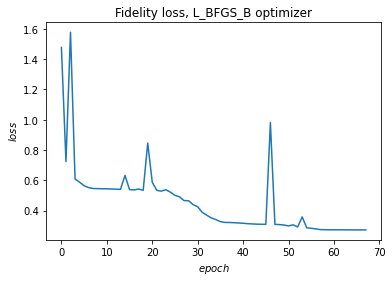

In [24]:
plt.plot(losses)
plt.title("Fidelity loss, L_BFGS_B optimizer")
plt.xlabel("$epoch$")
plt.ylabel("$loss$")

In [9]:
ws = [-1.18435404,  2.62239962,  0.95566011,  0.9121316 ,  2.26668431,
        0.3552154 ,  2.24345986,  0.97135536,  0.34448374, -0.52492525,
        0.01070006,  0.09177283,  1.23561492, -0.05720239, -0.02334014,
       -0.8456405 ,  0.98242761, -0.06394929]

from test_utils import get_metrics
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_train, qnn1, ws)

Accuracy:  0.9
tp:  80 tn:  100  fp:  19  fn:  1


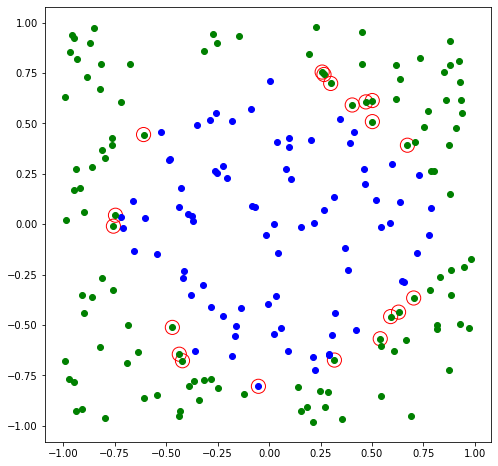

In [10]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_train, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

In [11]:
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_test, qnn1, ws)

Accuracy:  0.9125
tp:  858 tn:  967  fp:  145  fn:  30


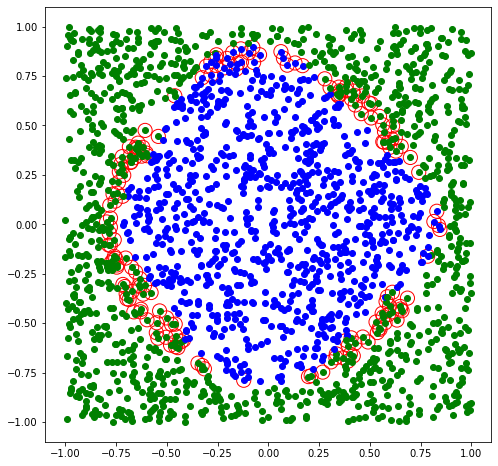

In [12]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()